In [1]:
import os
import shutil
import time
import subprocess
import corner
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import numba as nb
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM,Planck15
from astropy.convolution import convolve, convolve_fft, Moffat2DKernel, Gaussian2DKernel
import pandas as pd
from scipy import signal
import scipy.ndimage as ndimage
from scipy.signal import find_peaks
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{bm}'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
cosmo = Planck15
h = cosmo.H0.value/100

import matplotlib.ticker as mticker
import matplotlib as mpl
log_formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
#from matplotlib.ticker import StrMethodFormatter, NullFormatter

from numpy import unravel_index


def ds9_log(input_img):
    return np.log(1000*input_img+1)/np.log(1000)

def img_norm(input_img,min_v,max_v):
    input_img = np.where(input_img>=max_v, max_v, input_img)
    input_img = np.where(input_img<=min_v, min_v, input_img)
    input_img = (input_img-min_v)/(max_v-min_v)
    return input_img


def arcsec2pc(arcsec,z):
    length = arcsec*u.arcsec*(1/cosmo.arcsec_per_kpc_proper(z))
    length = length.to(u.pc)
    return length

def pc2arcsec(length,z):
    angular_length = length*u.pc*cosmo.arcsec_per_kpc_proper(z)
    angular_length = angular_length.to(u.arcsec)
    return angular_length

def saveFITS(image,Header,SavePath,FileName):
    hdu0 = fits.PrimaryHDU(image)
    #hdu_new = fits.HDUList([hdu0])
    hdu0.writeto(SavePath+FileName+'.fits',image, overwrite=True)
    return

def saveFITS_simple(image,SavePath,FileName):
    hdu0 = fits.PrimaryHDU(image)
    hdu_new = fits.HDUList([hdu0])
    hdu_new.writeto(SavePath+FileName+'.fits', overwrite=True)
    return

def Eq_Ellipse(x,y,x0,y0,a,b,theta):
    X = (x-x0)*np.cos(theta) + (y-y0)*np.sin(theta)
    Y = -(x-x0)*np.sin(theta) + (y-y0)*np.cos(theta)
    d = X**2/a**2 + Y**2/b**2
    return d

def Eq_Circle(x,y,x0,y0):
    X = (x-x0)
    Y = (y-y0)
    R = (X**2 + Y**2)**0.5
    return R

/Users/alexchow/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/alexchow/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def get_Pos_1stGuess_old(mock_lens_data):
    #mock_lens_data = fits.open(mock_lens_path)[0].data[4]
    #peaks = detect_peaks(mock_lens_data)
    peaks_filter = mock_lens_data > np.std(mock_lens_data)*5
    peaks = np.where(peaks_filter==True)
    plt.scatter(peaks[0],peaks[1])
    x_list,y_list = peaks[1],peaks[0]

    imgs_x , imgs_y = [],[]
    imgs_x_sub , imgs_y_sub = [],[]
    for i in range(len(peaks[0])):
        if i == len(peaks[0])-1:
            dist_list = ((x_list[i]-x_list)**2 + (y_list[i]-y_list)**2)**0.5
            dist_list_mask = np.where(dist_list<8)
            for j in dist_list_mask:
                imgs_x_sub.append(x_list[j])
                imgs_y_sub.append(y_list[j])
        else:
            dist_list = ((x_list[i]-x_list)**2 + (y_list[i]-y_list)**2)**0.5
            dist_list_mask = np.where(dist_list<8)
            dist_list_next = ((x_list[i+1]-x_list)**2 + (y_list[i+1]-y_list)**2)**0.5
            dist_list_next_mask = np.where(dist_list_next<8)
            if dist_list_mask[0].shape!=dist_list_next_mask[0].shape:
                for j in dist_list_mask:
                    imgs_x_sub.append(x_list[j])
                    imgs_y_sub.append(y_list[j])
            else:
                if (dist_list_next_mask[0]!=dist_list_mask[0]).all():
                    for j in dist_list_mask:
                        imgs_x_sub.append(x_list[j])
                        imgs_y_sub.append(y_list[j])
        if len(imgs_x_sub)!=0:
            imgs_x.append(np.median(imgs_x_sub))
            imgs_y.append(np.median(imgs_y_sub))
        imgs_x_sub , imgs_y_sub = [],[]

    imgs_x , imgs_y = np.asarray(imgs_x) , np.asarray(imgs_y)
    
    return imgs_x , imgs_y

def get_Pos_1stGuess(mock_lens_data):
    image = mock_lens_data

    # Apply Gaussian Filter to Denoise
    smoothed_image = image # No smoothing this time #ndimage.gaussian_filter(image, sigma=2)

    # Find Local Maxima
    threshold = np.std(image)*10  # 5 sig above noise
    local_max = (smoothed_image == ndimage.maximum_filter(smoothed_image, size=5)) & (smoothed_image > threshold)

    # Get Peak Coordinates
    peaks = np.argwhere(local_max)
    imgs_x , imgs_y = peaks[:, 1], peaks[:, 0]
    imgs_x , imgs_y = np.asarray(imgs_x) , np.asarray(imgs_y)
    imgs_x , imgs_y = imgs_x+1 , imgs_y+1
    return imgs_x , imgs_y

In [3]:
def create_mask_circle(x,y,image,Radius=5):
    X = np.linspace(0,image.shape[1]-1,image.shape[1])
    Y = np.linspace(0,image.shape[0]-1,image.shape[0])
    
    XX,YY = np.meshgrid(X-x,Y-y)
    RR = (XX**2 + YY**2)**0.5

    mask = np.zeros(image.shape)
    mask = np.int64(np.where(RR>Radius,1,mask))
    return mask


In [4]:
def write_imfit_config_str(img_x , img_y , image):
    string = ''
    string += 'X0' + '\t' + str(img_x) + '\n'
    string += 'Y0' + '\t' + str(img_y) + '\n'
    string += 'FUNCTION Gaussian' + '\n'
    string += 'PA' + '\t' + str(0) + '\t' + 'fixed' + '\n'
    string += 'ell' + '\t' + str(0) + '\t' + 'fixed' + '\n'
    string += 'I_0' + '\t' + str(image[int(img_y)][int(img_x)]) + '\n'
    string += 'sigma' + '\t' + str(0.8) + ' \n'
    return string


In [5]:
def save_imfit_config(config_str,output_FilePath):
    with open(output_FilePath, "w") as text_file:
        text_file.write(config_str)
    return 

def Combine_MCMC_Chain(file_name, mcmc_path):
    f = open(mcmc_path+file_name+'.'+str(int(0+1))+'.txt', "r")
    lines = []
    for line in f:
        line = line.strip()
        lines.append(line)

    for i in range(len(lines)):
        line = lines[i].strip()
        if not line.startswith('#'):
            header_id = i-1
            break
        
    header_str = lines[header_id]
    f.close()
    header = header_str.split()
    header.remove('#')

    IMFIT_mcmc_all = []
    for i in range(len(glob.glob(mcmc_path+file_name+'.*.txt'))):
        IMFIT_mcmc_all.append(pd.read_csv(mcmc_path+file_name+'.'+str(int(i+1))+'.txt',comment='#',header=None,sep=r'\s+'))

    IMFIT_mcmc = pd.concat(IMFIT_mcmc_all)
    del IMFIT_mcmc_all
    IMFIT_mcmc.to_csv(mcmc_path+file_name+'.txt',index=False,sep='\t',header=header)
    return 

In [41]:
main_folder_path = '/Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/'
sub_folder_path = '80/398065/398065_dm/z-1/'
#sub_folder_path = '80/398065/v2/398065/z-1/'
lens_file_name = 'withLight_Mock_i1_SNIa_z1_Cusp'
mock_lens_path = main_folder_path + sub_folder_path +lens_file_name+'.fits'

mock_lens_data = fits.open(mock_lens_path)[0].data[4]
imgs_x , imgs_y = get_Pos_1stGuess(mock_lens_data)
print(imgs_x , imgs_y)

# Create a folder to store the fitting results
folder4imfitfiles = main_folder_path+sub_folder_path+lens_file_name
if os.path.exists(folder4imfitfiles) == False:
    os.mkdir(folder4imfitfiles)
if os.path.exists(folder4imfitfiles+'/imfit_ImgPos') == False:
    os.mkdir(folder4imfitfiles+'/imfit_ImgPos')
    
folder4imfitfiles

[517 507 532 509] [508 516 523 527]


'/Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp'

In [42]:
# Save a copy of the mock img and it's noisemap
saveFITS_simple(mock_lens_data,folder4imfitfiles+'/imfit_ImgPos/','mock_obs')
saveFITS_simple(fits.open(mock_lens_path)[0].data[5],folder4imfitfiles+'/imfit_ImgPos/','mock_obs_noisemap')

# Path to imfit program
imfit_PATH = '/Users/alexchow/Desktop/Lensing/imfit/'

# Run imfit 
for i in range(len(imgs_x)):
    # Create and save the masking map
    mask = create_mask_circle(imgs_x[i],imgs_y[i],mock_lens_data,Radius=5)
    saveFITS_simple(np.int8(mask),folder4imfitfiles+'/imfit_ImgPos/','mask_img_'+str(i+1))
    # Create and save the config file
    text = write_imfit_config_str(imgs_x[i] , imgs_y[i] , mock_lens_data)
    config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'config_img_'+str(i+1)+'.txt'
    save_imfit_config(text,config_output_FilePath)
    # Print the command for running imfit
    imfit_cmd = (imfit_PATH+'./imfit ' +
                 folder4imfitfiles+'/imfit_ImgPos/mock_obs.fits' +
                 ' -mask ' + folder4imfitfiles+'/imfit_ImgPos/mask_img_'+str(i+1)+'.fits' + 
                ' -noise ' + folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits' + 
                ' -c ' + config_output_FilePath + 
                ' --save-params ' + folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt' + 
                ' --save-residual ' + folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_res.fits' )
    os.system(imfit_cmd)
    

	Image file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs.fits
	configuration file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/config_img_1.txt
	noise image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs_noisemap.fits
	mask image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mask_img_1.fits
	output residual (data - best-fit model) image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/Pos_Img_1_res.fits
	output best-fit parameter file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_C

	Image file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs.fits
	configuration file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/config_img_4.txt
	noise image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs_noisemap.fits
	mask image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mask_img_4.fits
	output residual (data - best-fit model) image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/Pos_Img_4_res.fits
	output best-fit parameter file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_C

In [43]:
################################################################
####################    Perform MCMC    ########################
################################################################
#i = 1
for i in range(len(imgs_x)):
    imfit_Bestfit_Path = folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt'
    imfit_Bestfit = pd.read_csv(imfit_Bestfit_Path,comment='#',header=None,sep='\t')

    mcmc_config_text = ''
    for j in range(imfit_Bestfit.shape[0]):
        bestfit_para = imfit_Bestfit[2][j]
        para_name = imfit_Bestfit[0][j]
        if para_name in ['X0','Y0']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-1/20) + ',' + str(bestfit_para+1/20) + '\n'
        elif para_name in ['FUNCTION Gaussian']:
            mcmc_config_text += para_name + '\n'
        elif para_name in ['PA','ell']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + 'fixed' + '\n'
        elif para_name in ['I_0']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-1/2) + ',' + str(bestfit_para+1/2) + '\n'
        elif para_name in ['sigma']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-1/20) + ',' + str(bestfit_para+1/20) + '\n'

    mcmc_config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'config_mcmc_img_'+str(i+1)+'.txt'
    save_imfit_config(mcmc_config_text,mcmc_config_output_FilePath)

    imfit_mcmc_cmd = (imfit_PATH+'./imfit-mcmc ' +
                     folder4imfitfiles+'/imfit_ImgPos/mock_obs.fits' +
                     ' --mask ' + folder4imfitfiles+'/imfit_ImgPos/mask_img_'+str(i+1)+'.fits' + 
                    ' --noise ' + folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits' + 
                    ' -c ' + mcmc_config_output_FilePath + 
                    ' -o ' + folder4imfitfiles+'/imfit_ImgPos/'+'mcmc_result_img_'+str(i+1)+'_chain'+
                    ' --gaussian-offset 0.02 ')
    os.system(imfit_mcmc_cmd)
    
    print('###################################################')
    print('###################################################')

	Image file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs.fits
	configuration file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/config_mcmc_img_1.txt
	noise image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs_noisemap.fits
	mask image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mask_img_1.fits
	MCMC Gaussian-offset sigma = 0.020000
Reading data image ("/Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs.fits") ...
naxis1 [# pixels/row] = 1039, naxis2 [# pixels/col] = 1039; nPixels_tot = 1079521
Reading mask image ("/Volumes/KINGSTON/Astro_Res

	Image file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs.fits
	configuration file = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/config_mcmc_img_4.txt
	noise image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs_noisemap.fits
	mask image = /Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mask_img_4.fits
	MCMC Gaussian-offset sigma = 0.020000
Reading data image ("/Volumes/KINGSTON/Astro_Research/illutrisTNG_Lensing/snapshot/80/398065/398065_dm/z-1/withLight_Mock_i1_SNIa_z1_Cusp/imfit_ImgPos/mock_obs.fits") ...
naxis1 [# pixels/row] = 1039, naxis2 [# pixels/col] = 1039; nPixels_tot = 1079521
Reading mask image ("/Volumes/KINGSTON/Astro_Res

accpetance rate = 20.01%
accpetance rate = 20.85%
accpetance rate = 28.59%
accpetance rate = 24.36%


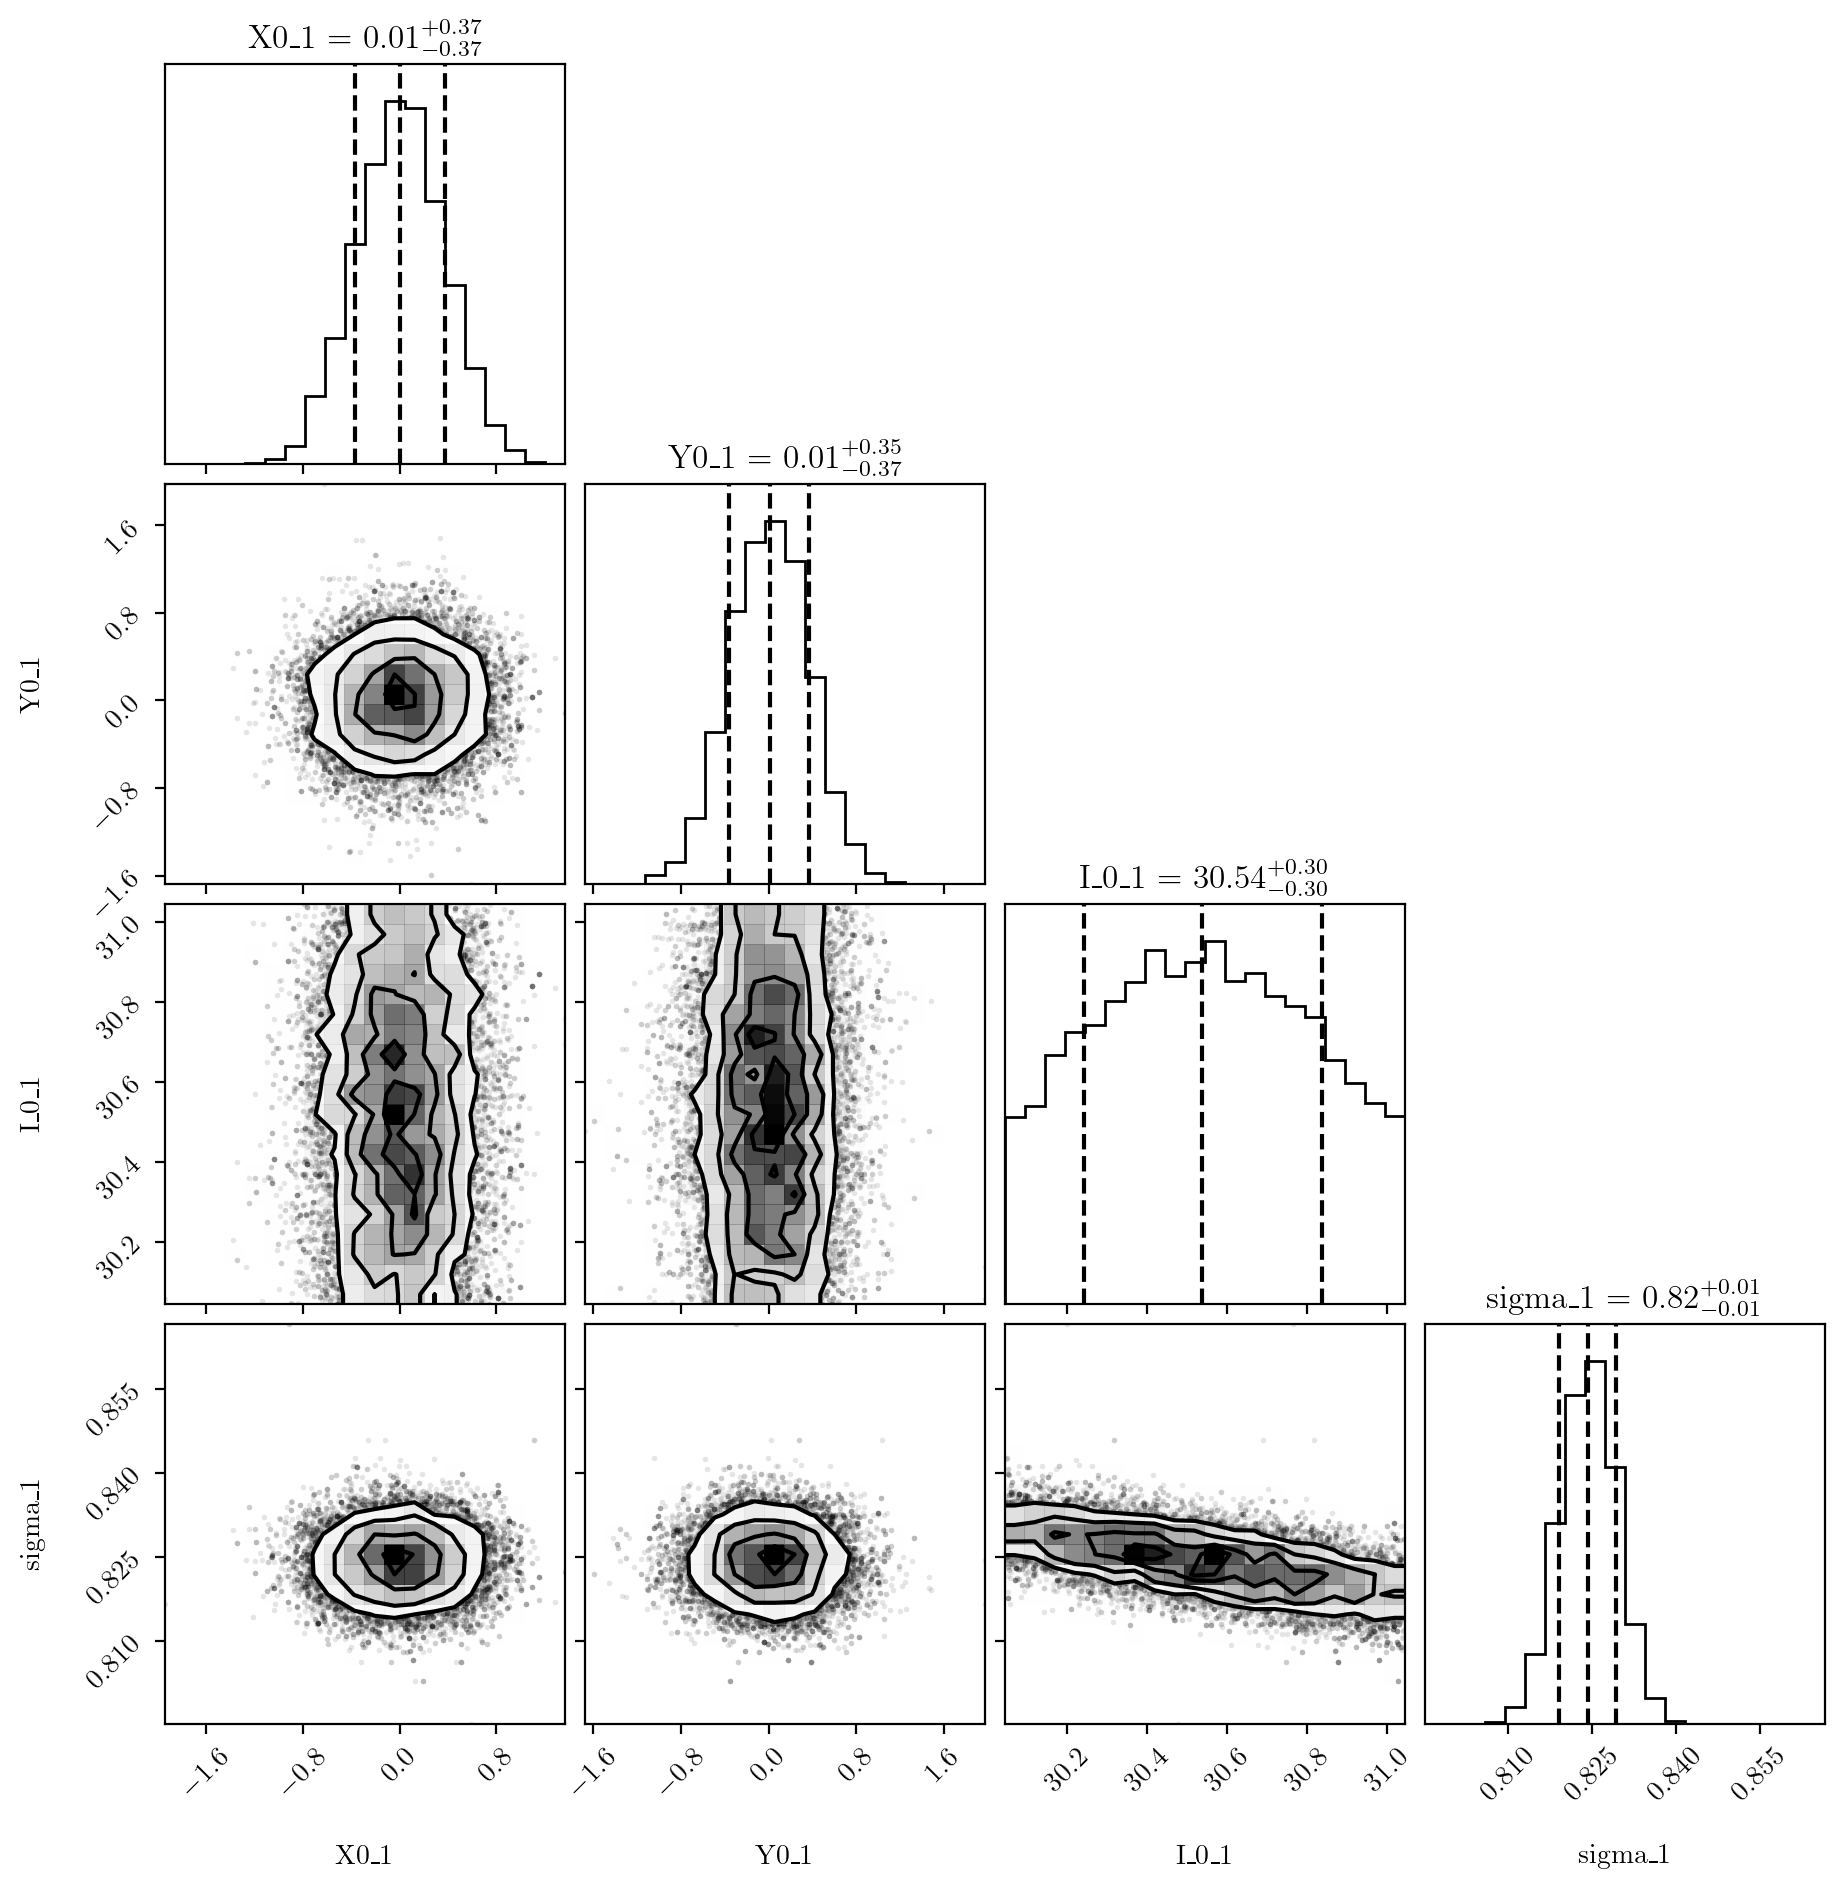

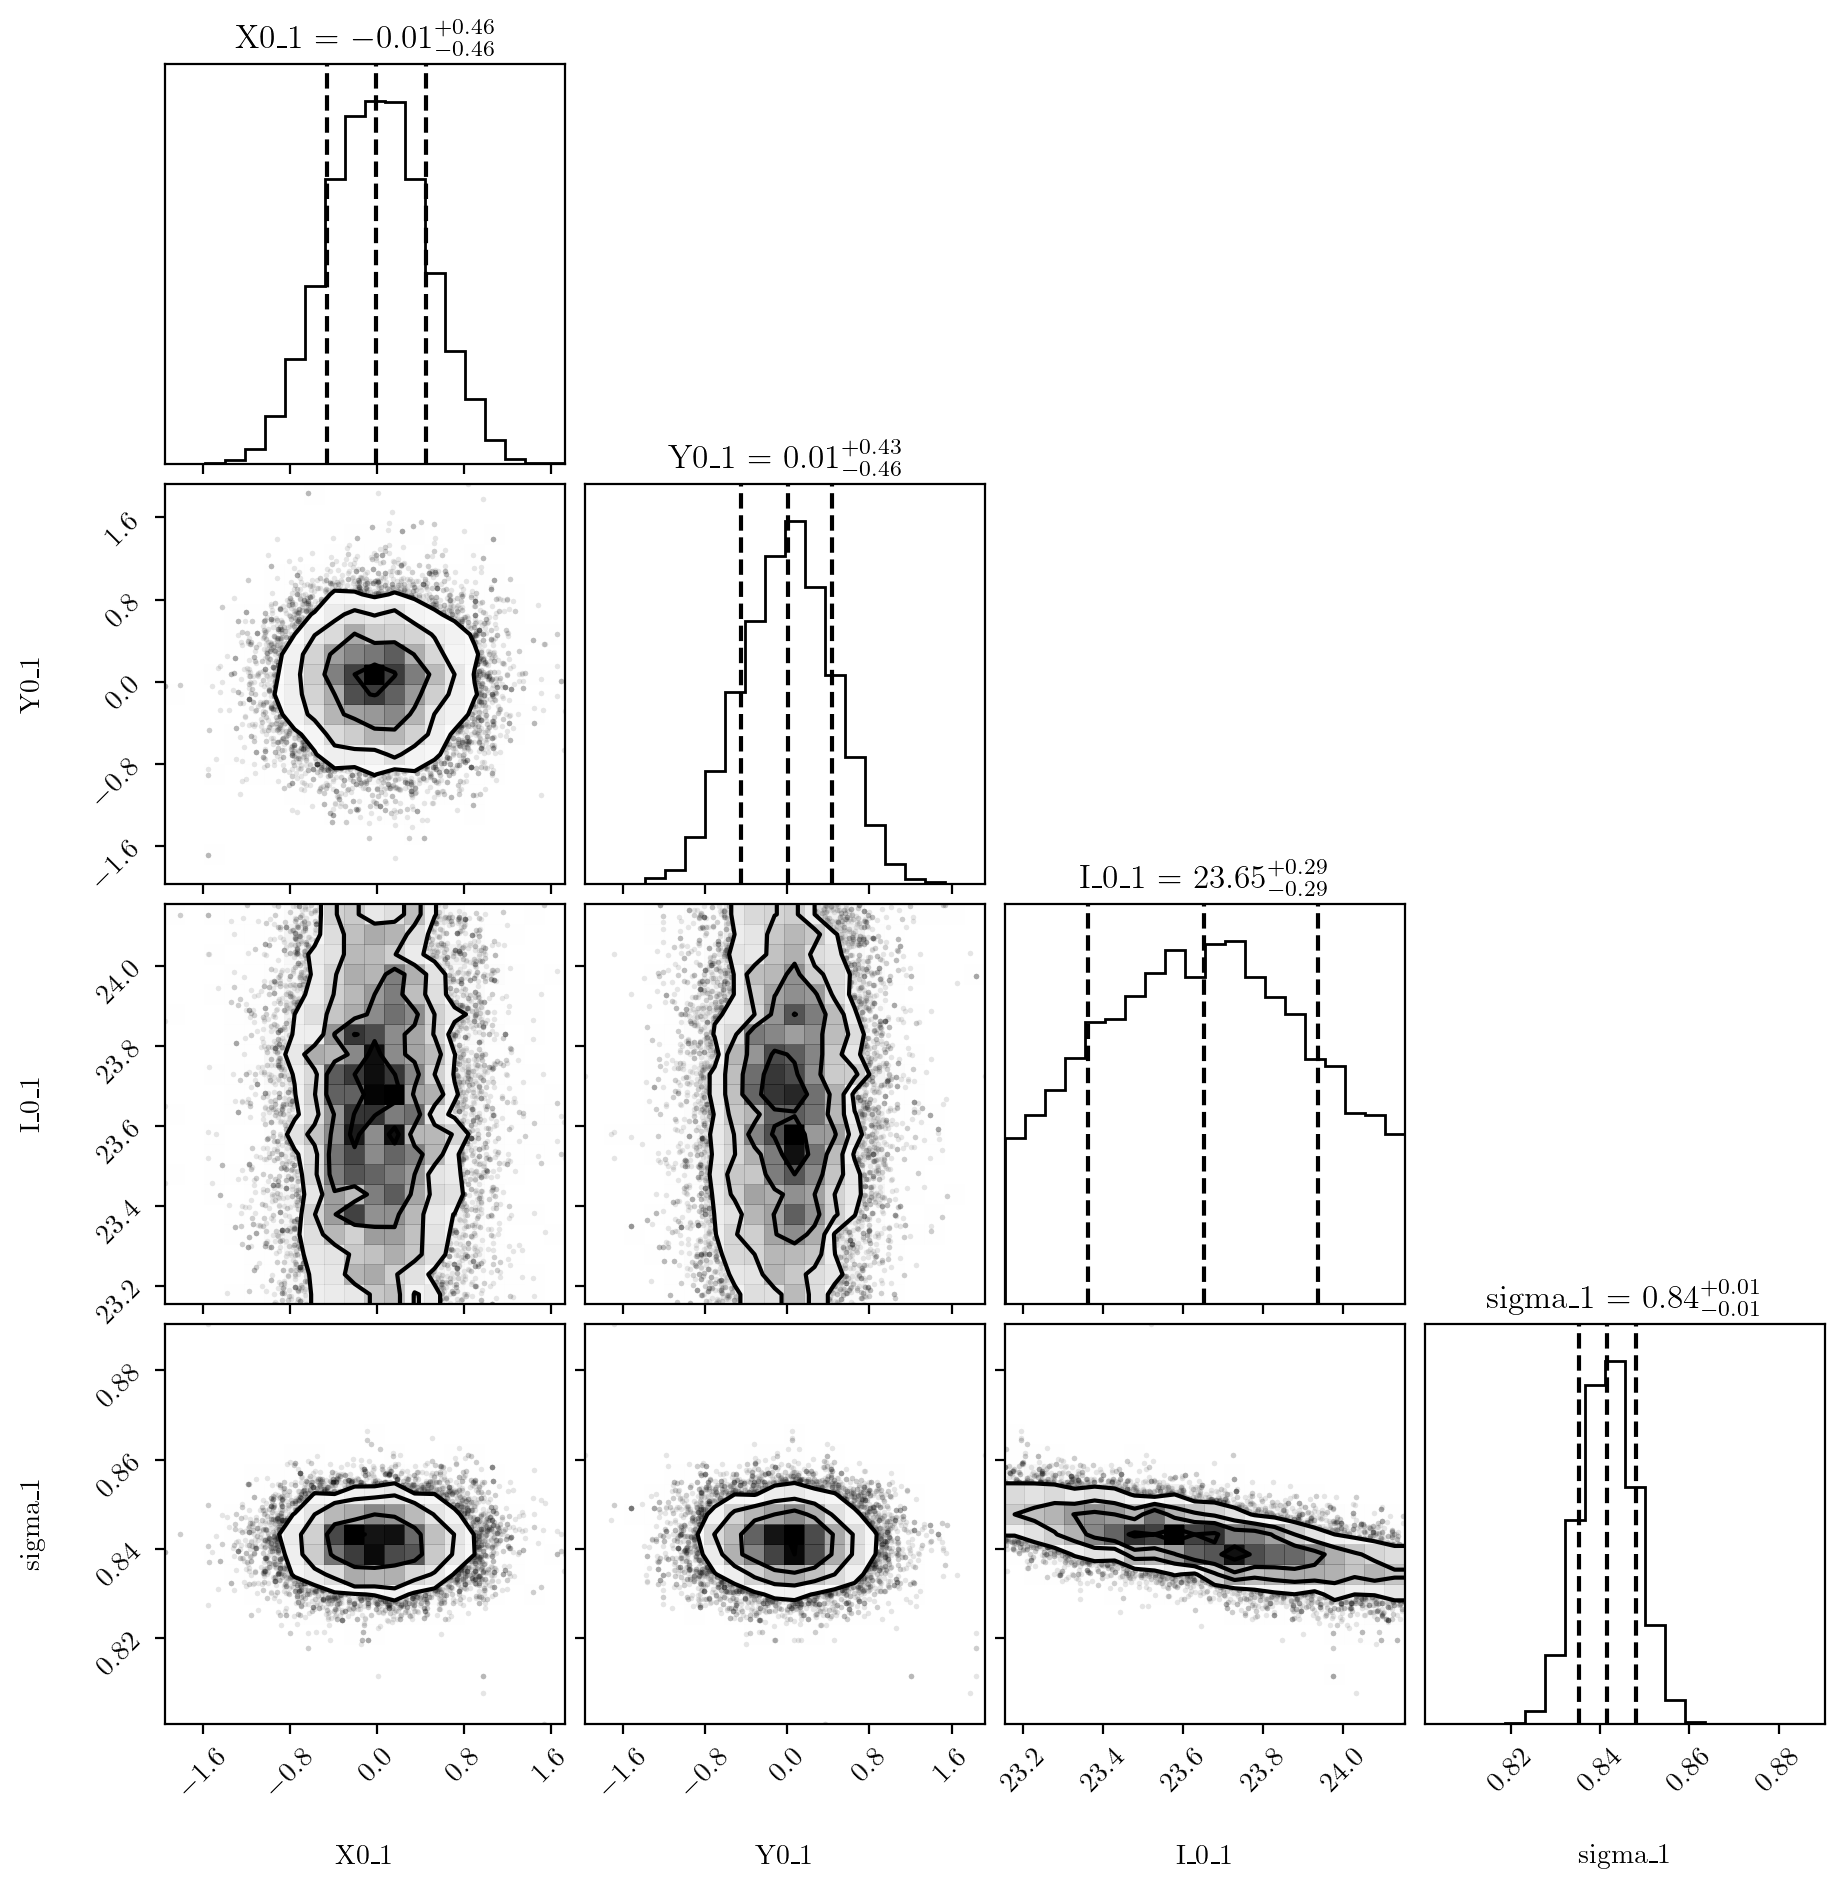

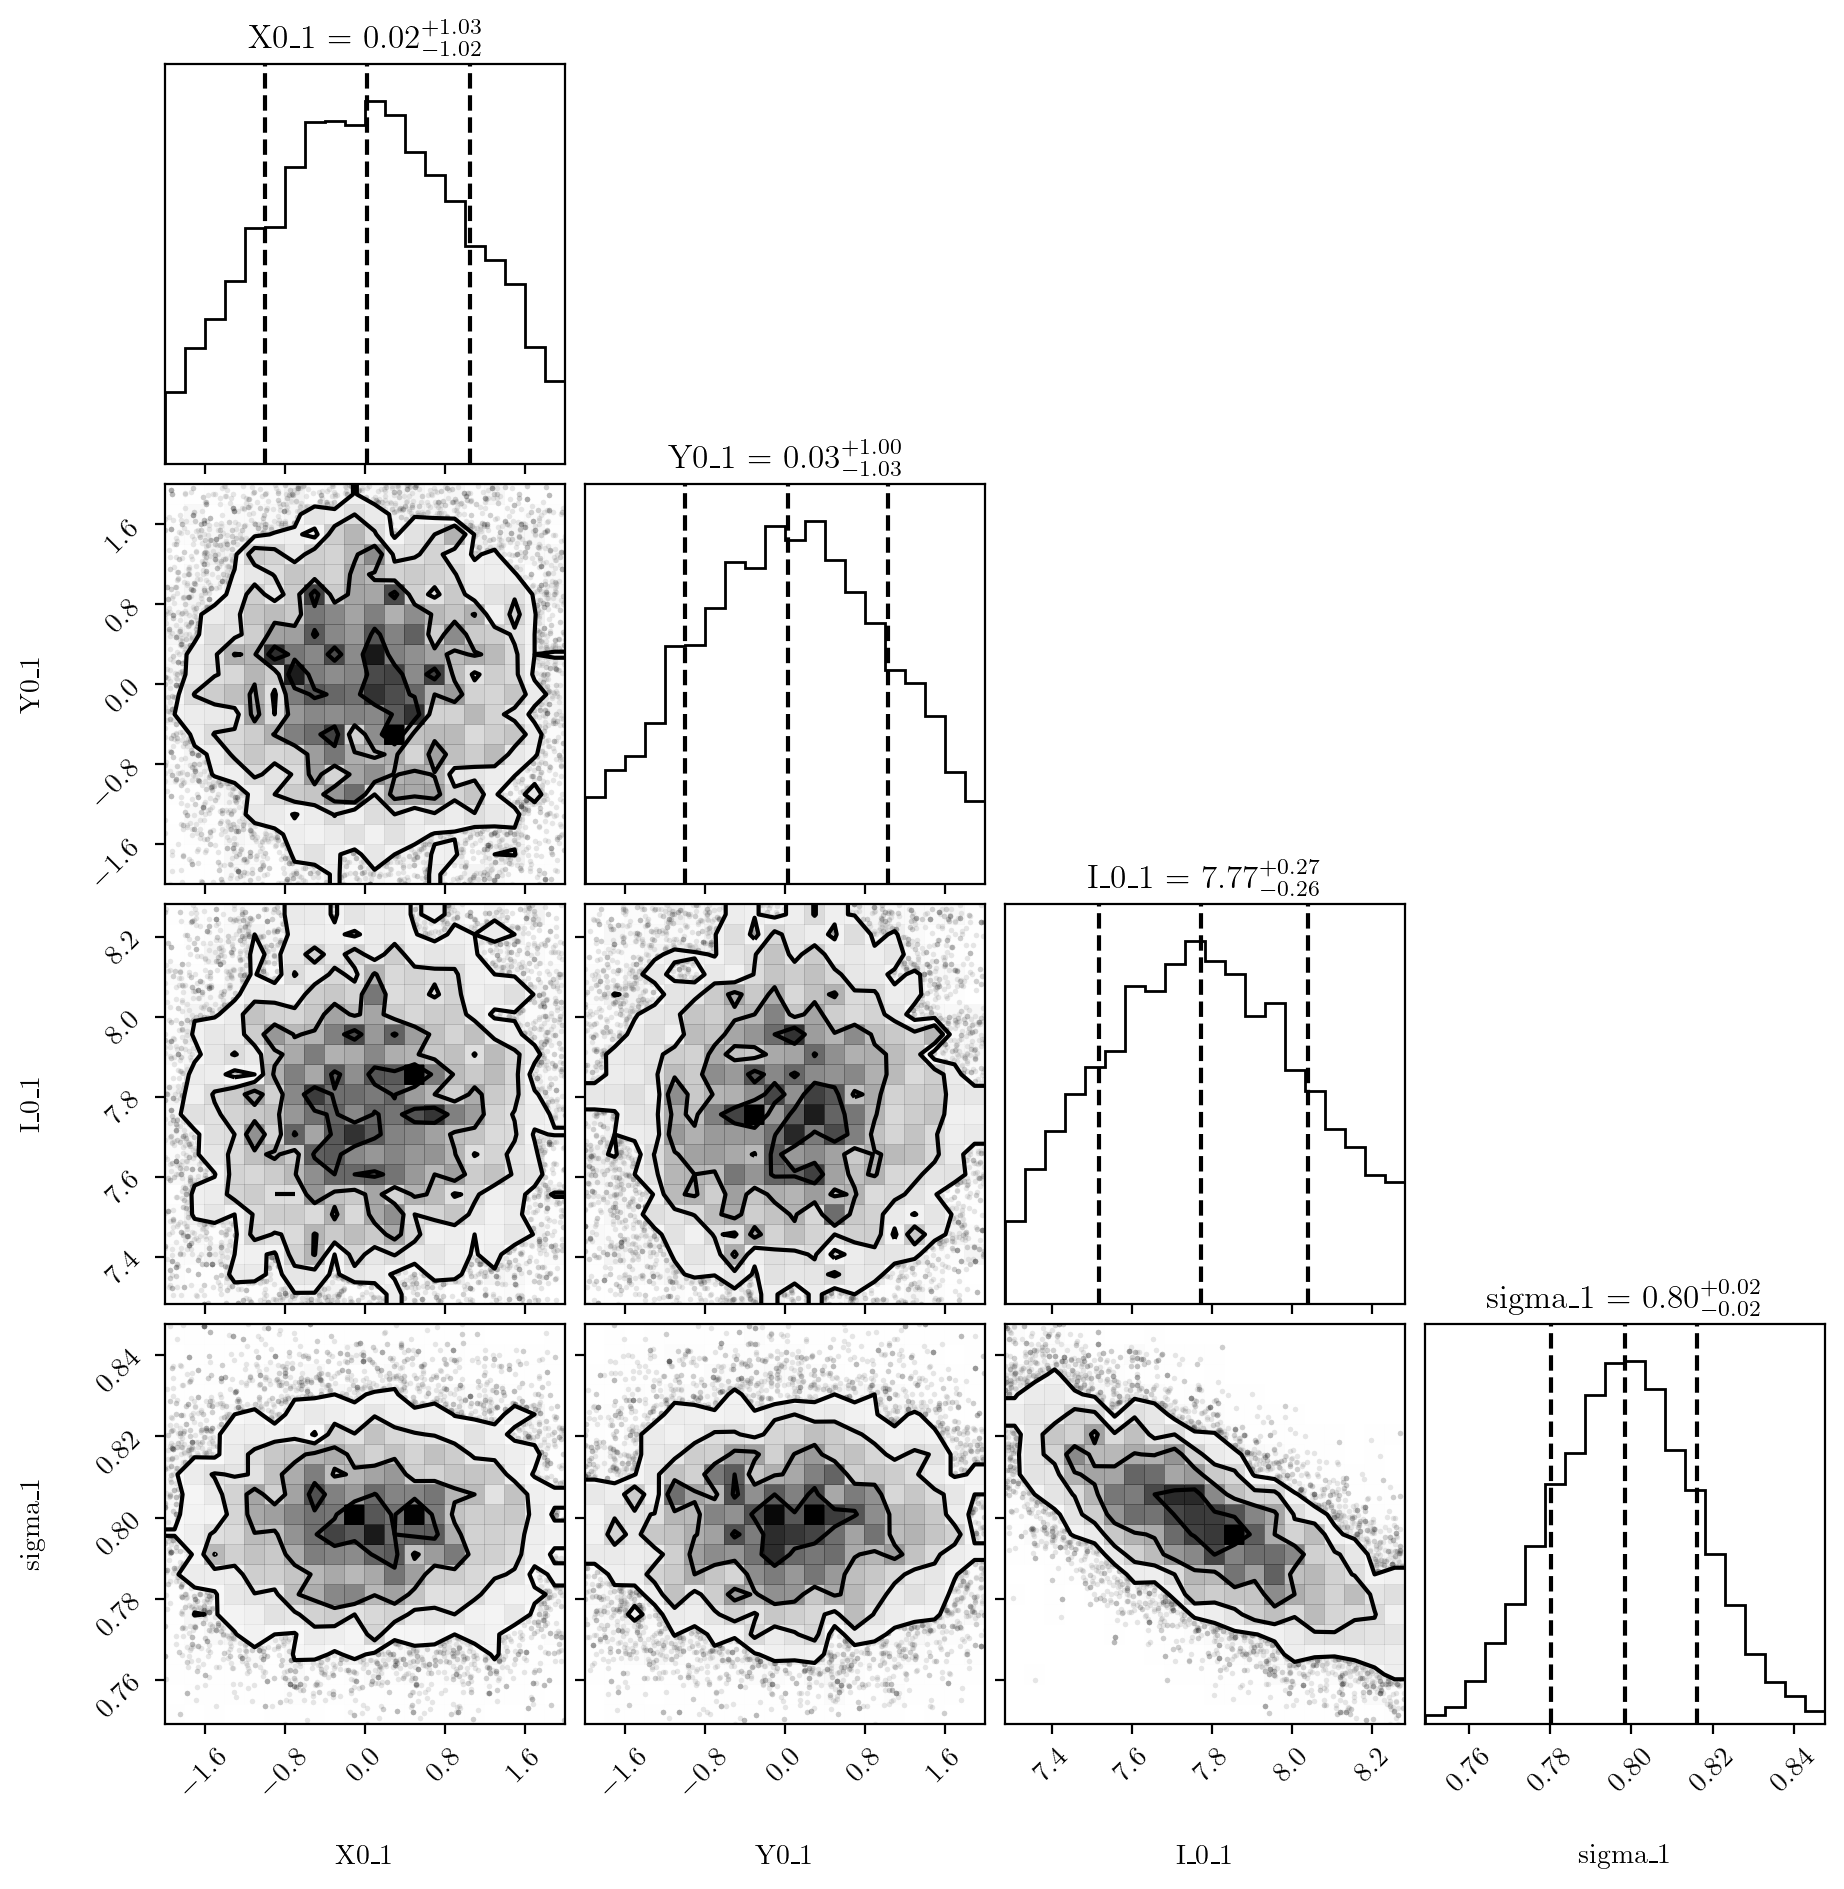

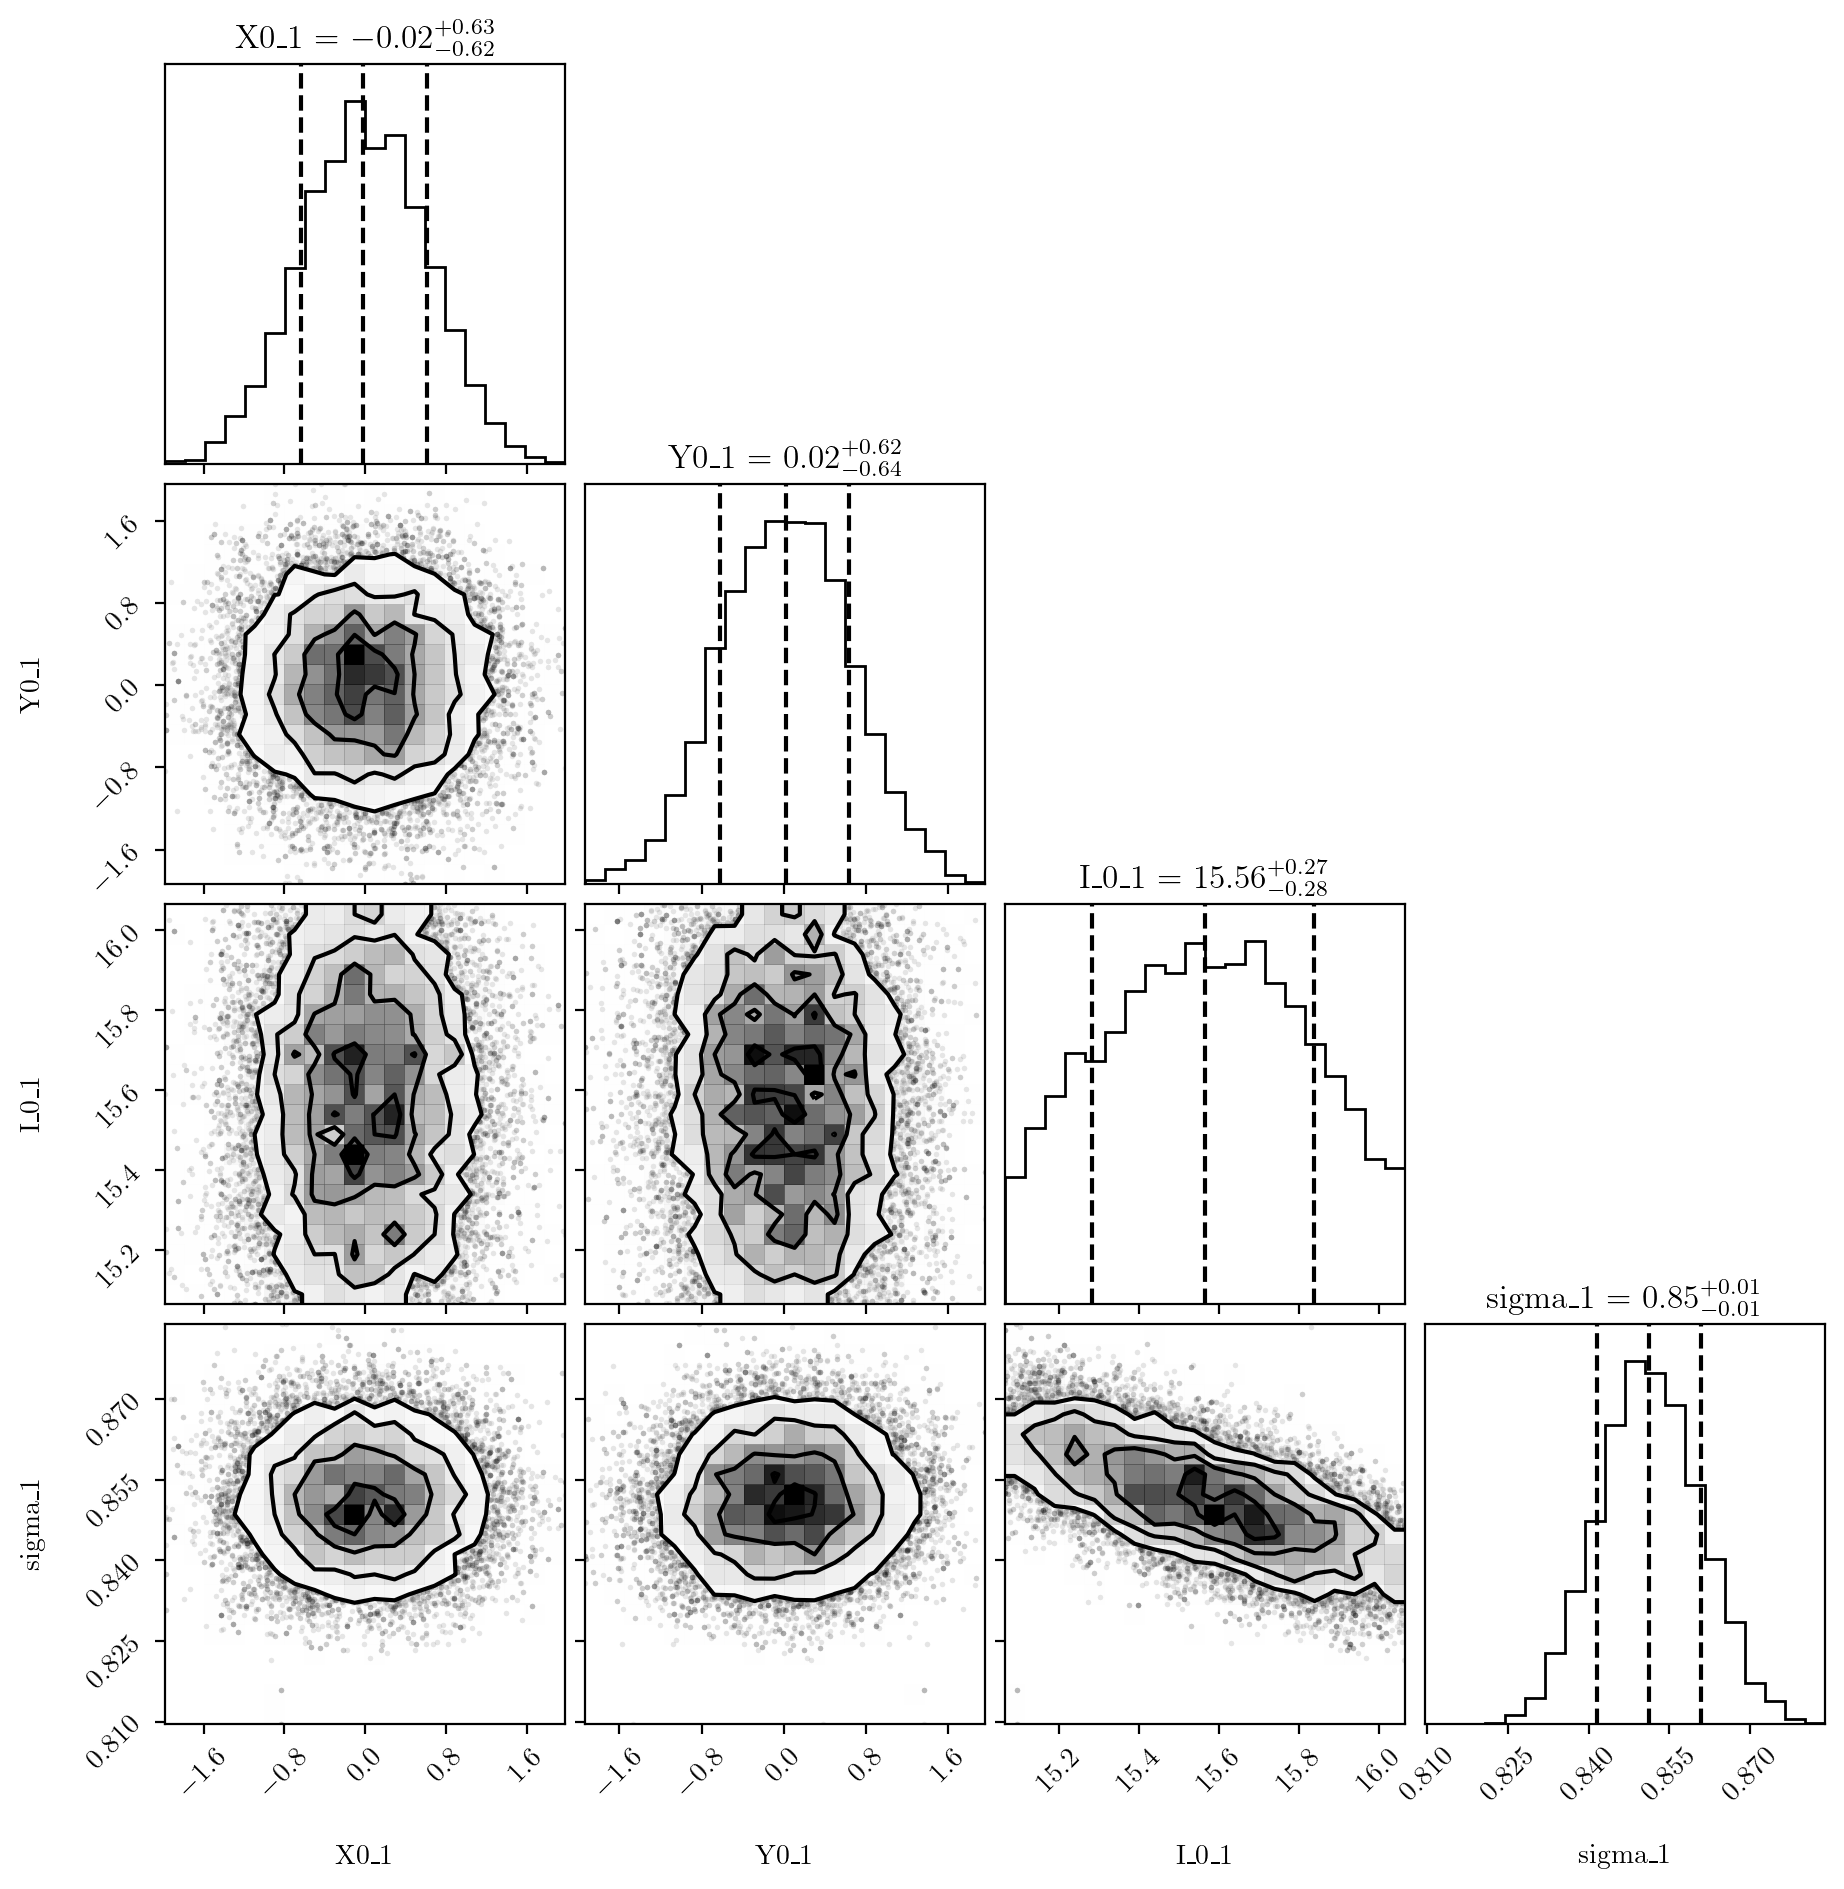

In [44]:
for i in range(len(imgs_x)):
    imfit_Bestfit_Path = folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt'
    imfit_Bestfit = pd.read_csv(imfit_Bestfit_Path,comment='#',header=None,sep='\t')
    bestfit_X0 = imfit_Bestfit[2][0]
    bestfit_Y0 = imfit_Bestfit[2][1]
    
    file_name = 'mcmc_result_img_'+str(i+1)+'_chain' # imfit output chain's file name
    mcmc_path = folder4imfitfiles+'/imfit_ImgPos/' # path to the folder containing the mcmc chain files
    Combine_MCMC_Chain(file_name,mcmc_path)
    data = pd.read_csv(mcmc_path+file_name+'.txt',sep='\s+')
    accpetance_rate = (data[data['accept']==1]).shape[0]/data.shape[0] * 100
    print('accpetance rate = '+ str(np.round(accpetance_rate,2)) + '%')
    data = data[data['accept']==1]
    data = data.drop(columns=['likelihood','burn-in','CR1','CR2','CR3','accept',
                             'PA_1','ell_1'])
    data['X0_1'] = (data['X0_1']-bestfit_X0)*0.04*1000
    data['Y0_1'] = (data['Y0_1']-bestfit_Y0)*0.04*1000
    data.to_numpy()
    # Plot it.
    figure = corner.corner(
        data,
        quantiles=[0.16, 0.5, 0.84],
        labels=list(data),
        show_titles=True,
        #title_kwargs={"fontsize": 16},
    )